# 0. Import Library

In [1]:
import os
if not os.path.exists("./tfdet"):
    !git clone -q http://github.com/burf/tfdetection.git
    !mv ./tfdetection/tfdet ./tfdet
    !rm -rf ./tfdetection

In [2]:
#ignore warning
import warnings, os
warnings.filterwarnings(action = "ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import tfdet

# 1. Balloon

1-1. Check Dataset

In [3]:
import os
path = "./balloon"
if not os.path.exists(path):
    !wget -qq --no-check-certificate http://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
    !unzip -qq balloon_dataset.zip
print(tfdet.dataset.util.tree_dir(path))

balloon/
    train/
        605521662_a470fef77f_b.jpg
        9330497995_4cf0438cb6_k.jpg
        5178670692_63a4365c9c_b.jpg
        ...
    val/
        4838031651_3e7b5ea5c7_b.jpg
        16335852991_f55de7958d_k.jpg
        24631331976_defa3bb61f_k.jpg
        ...


1-2. Sample Annotation

In [4]:
tr_path = os.path.join(path, "train/via_region_data.json")
te_path = os.path.join(path, "val/via_region_data.json")

tr_anno = tfdet.dataset.util.load_json(tr_path)
te_anno = tfdet.dataset.util.load_json(te_path)

print("train count:{0}, test count:{1}".format(len(tr_anno), len(te_anno)))
del tr_anno, te_anno

tr_data = tfdet.dataset.balloon.load_data(tr_path, mask = True)

train count:61, test count:13


x_true:(1536, 2048, 3), y_true:(1, 1), bbox_true:(1, 4), mask_true:(1, 1536, 2048, 1)


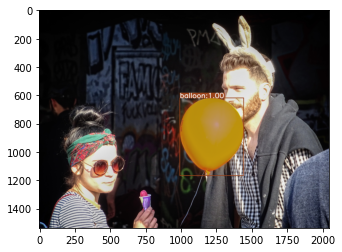

In [5]:
import matplotlib.pyplot as plt
try:
    out = next(tr_data)
    image, y_true, bbox_true, mask_true = out
except:
    image, y_true, bbox_true = out
    mask_true = None

image = tfdet.dataset.util.load_image(image)
image = tfdet.util.draw_bbox(image, bbox_true, y_true = y_true, mask_true = mask_true, label = tfdet.dataset.balloon.LABEL)

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

plt.figure()
plt.imshow(image)

1-3. Build Pipeline

In [6]:
tr_pipe = tfdet.dataset.balloon.load_pipe(tr_path, mask = True)
tr_pipe = tfdet.dataset.pipeline.load(tr_pipe)
#tr_pipe = tfdet.dataset.pipeline.args2dict(tr_pipe) #for train_model to object detection
tr_pipe = tfdet.dataset.pipeline.resize(tr_pipe, image_shape = [512, 512], keep_ratio = True)
tr_pipe = tfdet.dataset.pipeline.filter_annotation(tr_pipe, min_scale = 2, min_instance_area = 1)
tr_pipe = tfdet.dataset.pipeline.label_encode(tr_pipe, label = tfdet.dataset.balloon.LABEL)
tr_pipe = tfdet.dataset.pipeline.normalize(tr_pipe, mean = [123.675, 116.28, 103.53], std = [58.395, 57.12, 57.375], bbox_normalize = True)
tr_pipe = tfdet.dataset.pipeline.pad(tr_pipe, image_shape = [512, 512], max_pad_size = 100, mode = "both")
tr_pipe = tfdet.dataset.pipeline.cast(tr_pipe, map = {"x_true":tf.float32, "y_true":tf.float32, "bbox_true":tf.float32, "mask_true":tf.float32})
tr_pipe = tr_pipe.batch(4).prefetch(1)

out = next(iter(tr_pipe))
image, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

x_true:(4, 512, 512, 3), y_true:(4, 100, 1), bbox_true:(4, 100, 4), mask_true:(4, 100, 512, 512, 1)


# 2. Pascal VOC

2-1. Check Dataset

In [7]:
import os
path = "./VOC2007"
if not os.path.exists(path):
    #http://host.robots.ox.ac.uk/pascal/VOC/voc2007
    #http://host.robots.ox.ac.uk/pascal/VOC/voc2012
    raise Exception("Please try again after modifying the path or downloading the dataset.")
print(tfdet.dataset.util.tree_dir(path))

VOC2007/
    ImageSets/
        Segmentation/
            train.txt
            trainval.txt
            val.txt
        Layout/
            train.txt
            trainval.txt
            val.txt
        Main/
            train_train.txt
            bus_train.txt
            bottle_train.txt
            ...
    SegmentationClass/
        007417.png
        009348.png
        004644.png
        ...
    SegmentationObject/
        007417.png
        009348.png
        004644.png
        ...
    Annotations/
        007826.xml
        002786.xml
        006286.xml
        ...
    JPEGImages/
        003301.jpg
        006279.jpg
        008254.jpg
        ...


2-2. Sample Annotation

In [8]:
tr_path = os.path.join(path, "ImageSets/Main/train.txt")
te_path = os.path.join(path, "ImageSets/Main/val.txt")

tr_anno = tfdet.dataset.util.load_file(tr_path)
te_anno = tfdet.dataset.util.load_file(te_path)

print("train count:{0}, test count:{1}".format(len(tr_anno), len(te_anno)))
del tr_anno, te_anno

tr_data = tfdet.dataset.pascal_voc.load_data(tr_path, mask = True, truncated = True, difficult = False)

train count:2501, test count:2510


x_true:(281, 500, 3), y_true:(4, 1), bbox_true:(4, 4), mask_true:(4, 281, 500, 1)


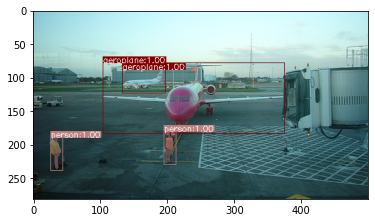

In [9]:
import matplotlib.pyplot as plt
try:
    out = next(tr_data)
    image, y_true, bbox_true, mask_true = out
except:
    image, y_true, bbox_true = out
    mask_true = None

image = tfdet.dataset.util.load_image(image)
image = tfdet.util.draw_bbox(image, bbox_true, y_true = y_true, mask_true = mask_true, label = tfdet.dataset.pascal_voc.LABEL, color = tfdet.dataset.pascal_voc.COLOR)

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

plt.figure()
plt.imshow(image)

2-3. Build Pipeline

In [10]:
tr_pipe = tfdet.dataset.pascal_voc.load_pipe(tr_path, mask = True, truncated = True, difficult = False)
tr_pipe = tfdet.dataset.pipeline.load(tr_pipe)
#tr_pipe = tfdet.dataset.pipeline.args2dict(tr_pipe) #for train_model to object detection
tr_pipe = tfdet.dataset.pipeline.resize(tr_pipe, image_shape = [512, 512], keep_ratio = True)
tr_pipe = tfdet.dataset.pipeline.filter_annotation(tr_pipe, min_scale = 2, min_instance_area = 1)
tr_pipe = tfdet.dataset.pipeline.label_encode(tr_pipe, label = tfdet.dataset.pascal_voc.LABEL)
tr_pipe = tfdet.dataset.pipeline.normalize(tr_pipe, mean = [123.675, 116.28, 103.53], std = [58.395, 57.12, 57.375], bbox_normalize = True)
tr_pipe = tfdet.dataset.pipeline.pad(tr_pipe, image_shape = [512, 512], max_pad_size = 100, mode = "both")
tr_pipe = tfdet.dataset.pipeline.cast(tr_pipe, map = {"x_true":tf.float32, "y_true":tf.float32, "bbox_true":tf.float32, "mask_true":tf.float32})
tr_pipe = tr_pipe.batch(4).prefetch(1)

out = next(iter(tr_pipe))
image, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

x_true:(4, 512, 512, 3), y_true:(4, 100, 1), bbox_true:(4, 100, 4), mask_true:(4, 100, 512, 512, 1)


# 3. MS COCO

3-1. Check Dataset

In [11]:
import os
path = "./coco"
if not os.path.exists(path):
    #https://cocodataset.org
    raise Exception("Please try again after modifying the path or downloading the dataset.")
print(tfdet.dataset.util.tree_dir(path))

coco/
    val2017/
        000000182611.jpg
        000000335177.jpg
        000000278705.jpg
        ...
    test2017/
        000000339995.jpg
        000000088328.jpg
        000000426344.jpg
        ...
    annotations/
        person_keypoints_val2017.json
        captions_val2017.json
        stuff_val2017.json
        ...
        deprecated-challenge2017/
            val-ids.txt
            train-ids.txt
        stuff_val2017_pixelmaps/
            000000122672.png
            000000030504.png
            000000353027.png
            ...
    train2017/
        000000109622.jpg
        000000160694.jpg
        000000308590.jpg
        ...


3-2. Sample Annotation

In [12]:
tr_anno_path = os.path.join(path, "annotations/instances_train2017.json")
te_anno_path = os.path.join(path, "annotations/instances_val2017.json")
tr_data_path = os.path.join(path, "train2017")
te_data_path = os.path.join(path, "val2017")

tr_anno = tfdet.dataset.util.load_json(tr_anno_path)
te_anno = tfdet.dataset.util.load_json(te_anno_path)
print("train count:{0}, test count:{1}".format(len(tr_anno["images"]), len(te_anno["images"])))
del tr_anno, te_anno

tr_data = tfdet.dataset.coco.load_data(tr_anno_path, tr_data_path, mask = True, crowd = False, label = tfdet.dataset.coco.LABEL)

train count:118287, test count:5000


loading annotations into memory...
Done (t=13.79s)
creating index...
index created!
x_true:(360, 640, 3), y_true:(4, 1), bbox_true:(4, 4), mask_true:(4, 360, 640, 1)


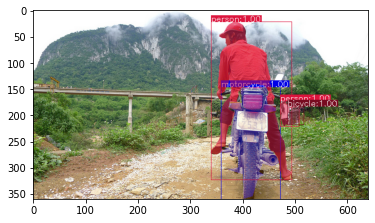

In [13]:
import matplotlib.pyplot as plt
try:
    out = next(tr_data)
    image, y_true, bbox_true, mask_true = out
except:
    image, y_true, bbox_true = out
    mask_true = None

image = tfdet.dataset.util.load_image(image)
image = tfdet.util.draw_bbox(image, bbox_true, y_true = y_true, mask_true = mask_true, label = tfdet.dataset.coco.LABEL, color = tfdet.dataset.coco.COLOR)

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

plt.figure()
plt.imshow(image)

3-3. Build Pipeline

In [14]:
tr_pipe = tfdet.dataset.coco.load_pipe(tr_anno_path, tr_data_path, mask = True, crowd = False, label = tfdet.dataset.coco.LABEL)
tr_pipe = tfdet.dataset.pipeline.load(tr_pipe)
#tr_pipe = tfdet.dataset.pipeline.args2dict(tr_pipe) #for train_model to object detection
tr_pipe = tfdet.dataset.pipeline.resize(tr_pipe, image_shape = [512, 512], keep_ratio = True)
tr_pipe = tfdet.dataset.pipeline.filter_annotation(tr_pipe, min_scale = 2, min_instance_area = 1)
tr_pipe = tfdet.dataset.pipeline.label_encode(tr_pipe, label = tfdet.dataset.coco.LABEL)
tr_pipe = tfdet.dataset.pipeline.normalize(tr_pipe, mean = [123.675, 116.28, 103.53], std = [58.395, 57.12, 57.375], bbox_normalize = True)
tr_pipe = tfdet.dataset.pipeline.pad(tr_pipe, image_shape = [512, 512], max_pad_size = 100, mode = "both")
tr_pipe = tfdet.dataset.pipeline.cast(tr_pipe, map = {"x_true":tf.float32, "y_true":tf.float32, "bbox_true":tf.float32, "mask_true":tf.float32})
tr_pipe = tr_pipe.batch(4).prefetch(1)

out = next(iter(tr_pipe))
image, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

x_true:(4, 512, 512, 3), y_true:(4, 100, 1), bbox_true:(4, 100, 4), mask_true:(4, 100, 512, 512, 1)
